# Loop Detection

## Of long (>1 minute) Samples


In [34]:
import os
import pretty_midi
from midi_player import MIDIPlayer
from midi_player.stylers import dark

midi_file = os.path.join("data", "inputs", "1.mid")
midi_data = pretty_midi.PrettyMIDI(midi_file)
piano_roll = midi_data.get_piano_roll()

MIDIPlayer(midi_file, 400, styler=dark)

## Chroma SSM


In [35]:
import ssm_utils
import numpy as np

sr = 2

chroma = midi_data.get_chroma(sr)
ssm_chroma = np.dot(np.transpose(chroma), chroma)
novelty_curve = ssm_utils.compute_novelty_ssm(ssm_chroma, L=1, exclude=True)
boundary = ssm_utils.get_boundaries(novelty_curve, np.array(range(0, chroma.shape[1])))

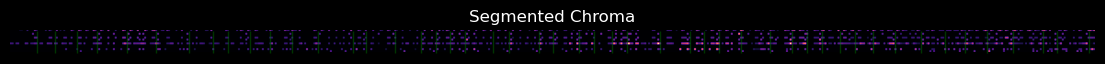

In [36]:
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(14, 10))
plt.imshow(chroma / chroma.max(), cmap="magma")
plt.vlines(boundary[1], 0, 12, "g", linewidth=1, alpha=0.4) # type: ignore
# plt.plot(
#     (1 - novelty_curve / novelty_curve.max()) * ssm_pr.shape[0],
#     "g",
#     linewidth=1,
#     alpha=0.4,
# )
plt.title("Segmented Chroma")
plt.axis("off")
plt.show()

## Segment the MIDI


In [37]:
notes = midi_data.instruments[0].notes
segmented_midi = ssm_utils.boundary_split_t(notes, boundary[0] / sr)

In [42]:
boundary

(array([  0.,  14.,  24.,  36.,  47.,  63.,  79.,  97., 110., 118., 130.,
        141., 153., 167., 186., 193., 209., 223., 231., 239., 247., 262.,
        271., 287., 295., 309., 317., 327., 335., 353., 369., 377., 385.,
        397., 413., 425., 433., 441., 451., 459., 469., 481., 495., 508.,
        519., 531., 545., 561., 569., 586., 589.]),
 array([ 14,  24,  36,  47,  63,  79,  97, 110, 118, 130, 141, 153, 167,
        186, 193, 209, 223, 231, 239, 247, 262, 271, 287, 295, 309, 317,
        327, 335, 353, 369, 377, 385, 397, 413, 425, 433, 441, 451, 459,
        469, 481, 495, 508, 519, 531, 545, 561, 569, 586]))

In [41]:
segmented_midi.keys()

dict_keys([0, 7, 12, 18, 23, 31, 39, 48, 55, 59, 65, 70, 76, 83, 93, 96, 104, 111, 115, 119, 123, 131, 135, 143, 147, 154, 158, 163, 167, 176, 184, 188, 192, 198, 206, 212, 216, 220, 225, 229, 234, 240, 247, 254, 259, 265, 272, 280, 284, 293, 294])

In [38]:
def normalize_midi(mid: pretty_midi.PrettyMIDI, end):
  """Normalize MIDI file so that the first note is at 0.0s."""
  for instrument in mid.instruments:
    if not instrument.notes:
      continue
    first_note_start = instrument.notes[0].start
    for note in instrument.notes:
      note.start -= first_note_start
      note.end -= first_note_start
      if note.end > end:
        print(f"found note that trails past {end}", note)
        note.end = end
  return mid

In [40]:
from pathlib import Path

# clear old files
dir_out = os.path.join("data", "outputs", "ssm", f"{Path(midi_file).stem}")
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
else:
    os.system(f"rm -rf {dir_out}/*")

# write segments out
for i, (k, bin) in enumerate(segmented_midi.items()):
    if len(bin) < 1:
        continue
    print(f"Working with segment {i} - {k}")
    segment = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program("Acoustic Grand Piano")
    piano = pretty_midi.Instrument(program=piano_program, name=f"{Path(midi_file).stem}-{i}-sr{sr}")

    for note in bin:
        piano.notes.append(
            pretty_midi.Note(note.velocity, note.pitch, note.start - k, note.end - k)
        )

    segment.instruments.append(piano)
    segment = normalize_midi(segment, list(segmented_midi.items())[i + 1][0])

    segment.write(
        os.path.join(
            "data",
            "outputs",
            "ssm",
            f"{Path(midi_file).stem}",
            f"{Path(midi_file).stem}-{i}-sr{sr}.mid",
        )
    )

found note that trails past 7 Note(start=6.776042, end=7.213542, pitch=36, velocity=31)
found note that trails past 7 Note(start=6.770833, end=7.531250, pitch=60, velocity=40)
found note that trails past 7 Note(start=6.760417, end=7.531250, pitch=64, velocity=53)
found note that trails past 7 Note(start=6.765625, end=7.546875, pitch=55, velocity=50)


## Draw MIDI file


In [ ]:
import matplotlib.patches as patches

pm_segment = pretty_midi.PrettyMIDI(
    os.path.join(
        "data",
        "outputs",
        f"{Path(midi_file).stem}",
        f"{Path(midi_file).stem}-2.mid",
    )
)

fig, ax = plt.subplots()

for note in pm_segment.instruments[0].notes:
    rect = patches.Rectangle(
        (note.start, note.pitch), note.end - note.start, 1, color="green"
    )
    ax.add_patch(rect)

ax.set_xlabel("Time (s)")
ax.set_ylabel("MIDI Note")
ax.set_title("Piano Roll")

plt.ylim(20, 108)  # MIDI note range for a piano
plt.xlim(0, np.ceil(pm_segment.instruments[0].notes[-1].end))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/outputs/1/1-2.mid'